In [ ]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def give_bkg_mc_weights_gaisser(pr_df: pd.DataFrame):
    rootfile = "/home/zhonghua/data/exposure_Gaisser.root"
    with uproot.open(rootfile) as f:
        hWeight = f["hWeight"]
        edges_E = hWeight.axes[0].edges()  # Energy bin edges
        edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
        weights_2d = hWeight.values()

    def add_weights(trueE, rec_zenith, weights_2d):
        trueE=np.log10(trueE/1e3)
        rec_zenith=180/np.pi*rec_zenith
        bin_idx_E = np.digitize(trueE, edges_E) - 1
        bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
        if bin_idx_E >= weights_2d.shape[0]:
            bin_idx_E = weights_2d.shape[0] - 1
        if bin_idx_Zen >= weights_2d.shape[1]:
            bin_idx_Zen = weights_2d.shape[1] - 1
        return weights_2d[bin_idx_E, bin_idx_Zen]
    
    pr_df['gaisser_weight']=pr_df.apply(lambda row: add_weights(row['trueE'],row['rec_theta'],weights_2d),axis=1)
    pr_df['gaisser_weight']=pr_df['gaisser_weight']/86400
    # print(f"======> Total expected background MC events after weighting: {pr_df['gaisser_weight'].sum()} ======")
    return pr_df

def load_pos(flag:int):
    ED_pos_file = None
    MD_pos_file = None
    script_dir = "/home/zhonghua/data/Dataset_Filted/config"
    if flag==7:
        ED_pos_file=f'{script_dir}/ED_pos_all_MC.txt'
        MD_pos_file=f'{script_dir}/MD_pos_all_MC.txt'
    else:
        MD_pos_file=f'{script_dir}/MD_pos_1188.txt'
        if flag>20191224 and flag<20201201:
            ED_pos_file=f'{script_dir}/ED_pos_half.txt'
        elif flag>20201130 and flag<20210720:
            ED_pos_file=f'{script_dir}/ED_pos_3978.txt'
        elif flag>20210719 and flag<20210807:
            ED_pos_file=f'{script_dir}/ED_pos_5216up_20210720.txt'
        elif flag>20210806 and flag<20210818:
            ED_pos_file=f'{script_dir}/ED_pos_5216up_20210807.txt'
        elif flag>20210817 and flag<20220525:
            ED_pos_file=f'{script_dir}/ED_pos_5216up_20210818.txt'
        elif flag>20220525 and flag<20220601:
            ED_pos_file=f'{script_dir}/ED_pos_5216up_20220520.txt'
        elif flag>20220531 and flag<20220705:
            ED_pos_file=f'{script_dir}/ED_pos_5216up_20220601.txt'
        elif flag>20220704:
            ED_pos_file=f'{script_dir}/ED_pos_5216up_20220705.txt'
    
    if ED_pos_file is not None:
        if os.path.exists(ED_pos_file) and os.path.exists(MD_pos_file):
            ED_pos=pd.read_csv(ED_pos_file,  sep=r'\s+',   skiprows=1,header=None, names=["id","x","y","z"])
            MD_pos=pd.read_csv(MD_pos_file,  sep=r'\s+',   skiprows=1,header=None, names=["id","x","y","z"])
            return ED_pos,MD_pos
    else:

        raise ValueError("wrong flag")
    


ED_pos, MD_pos = load_pos(7); print("MD_pos",MD_pos.shape,"ED_pos",ED_pos.shape)
import matplotlib.pyplot as plt

def plot_detector_positions(ED_pos, MD_pos):
    # 设置全局字体为衬线体（类似 Times New Roman），符合论文发表习惯
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["mathtext.fontset"] = "stix" # 数学符号字体
    
    fig, ax = plt.subplots(figsize=(7, 6), dpi=300) # 高分辨率输出
    
    # 绘制 ED 散点 (数量较多，使用较小的点和半透明度)
    ax.scatter(ED_pos['x'], ED_pos['y'], 
               s=8, c='#1f77b4', alpha=0.6, label='ED', edgecolors='none')
    
    # 绘制 MD 散点 (数量较少，颜色对比明显)
    ax.scatter(MD_pos['x'], MD_pos['y'], 
               s=12, c='#d62728', alpha=0.8, label='MD', marker='x', linewidths=1)
    
    # 设置坐标轴范围
    limit = 660
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    
    # 坐标轴标签 (通常带单位)
    ax.set_xlabel('x [m]', fontsize=12)
    ax.set_ylabel('y [m]', fontsize=12)
    
    # 优化刻度
    ax.tick_params(direction='in', top=True, right=True, labelsize=10)
    
    # 设置等比例坐标轴 (保证圆形分布不被拉伸)
    ax.set_aspect('equal')
    
    # 图例设置 (边框去掉，位置自适应)
    ax.legend(loc='upper right', frameon=True, fontsize=10, shadow=False).get_frame().set_edgecolor('0.8')
    
    plt.tight_layout()
    plt.savefig("./figures/detector_layout.pdf", bbox_inches='tight', pad_inches=0.1)
    plt.show()

# 调用函数
plot_detector_positions(ED_pos, MD_pos)


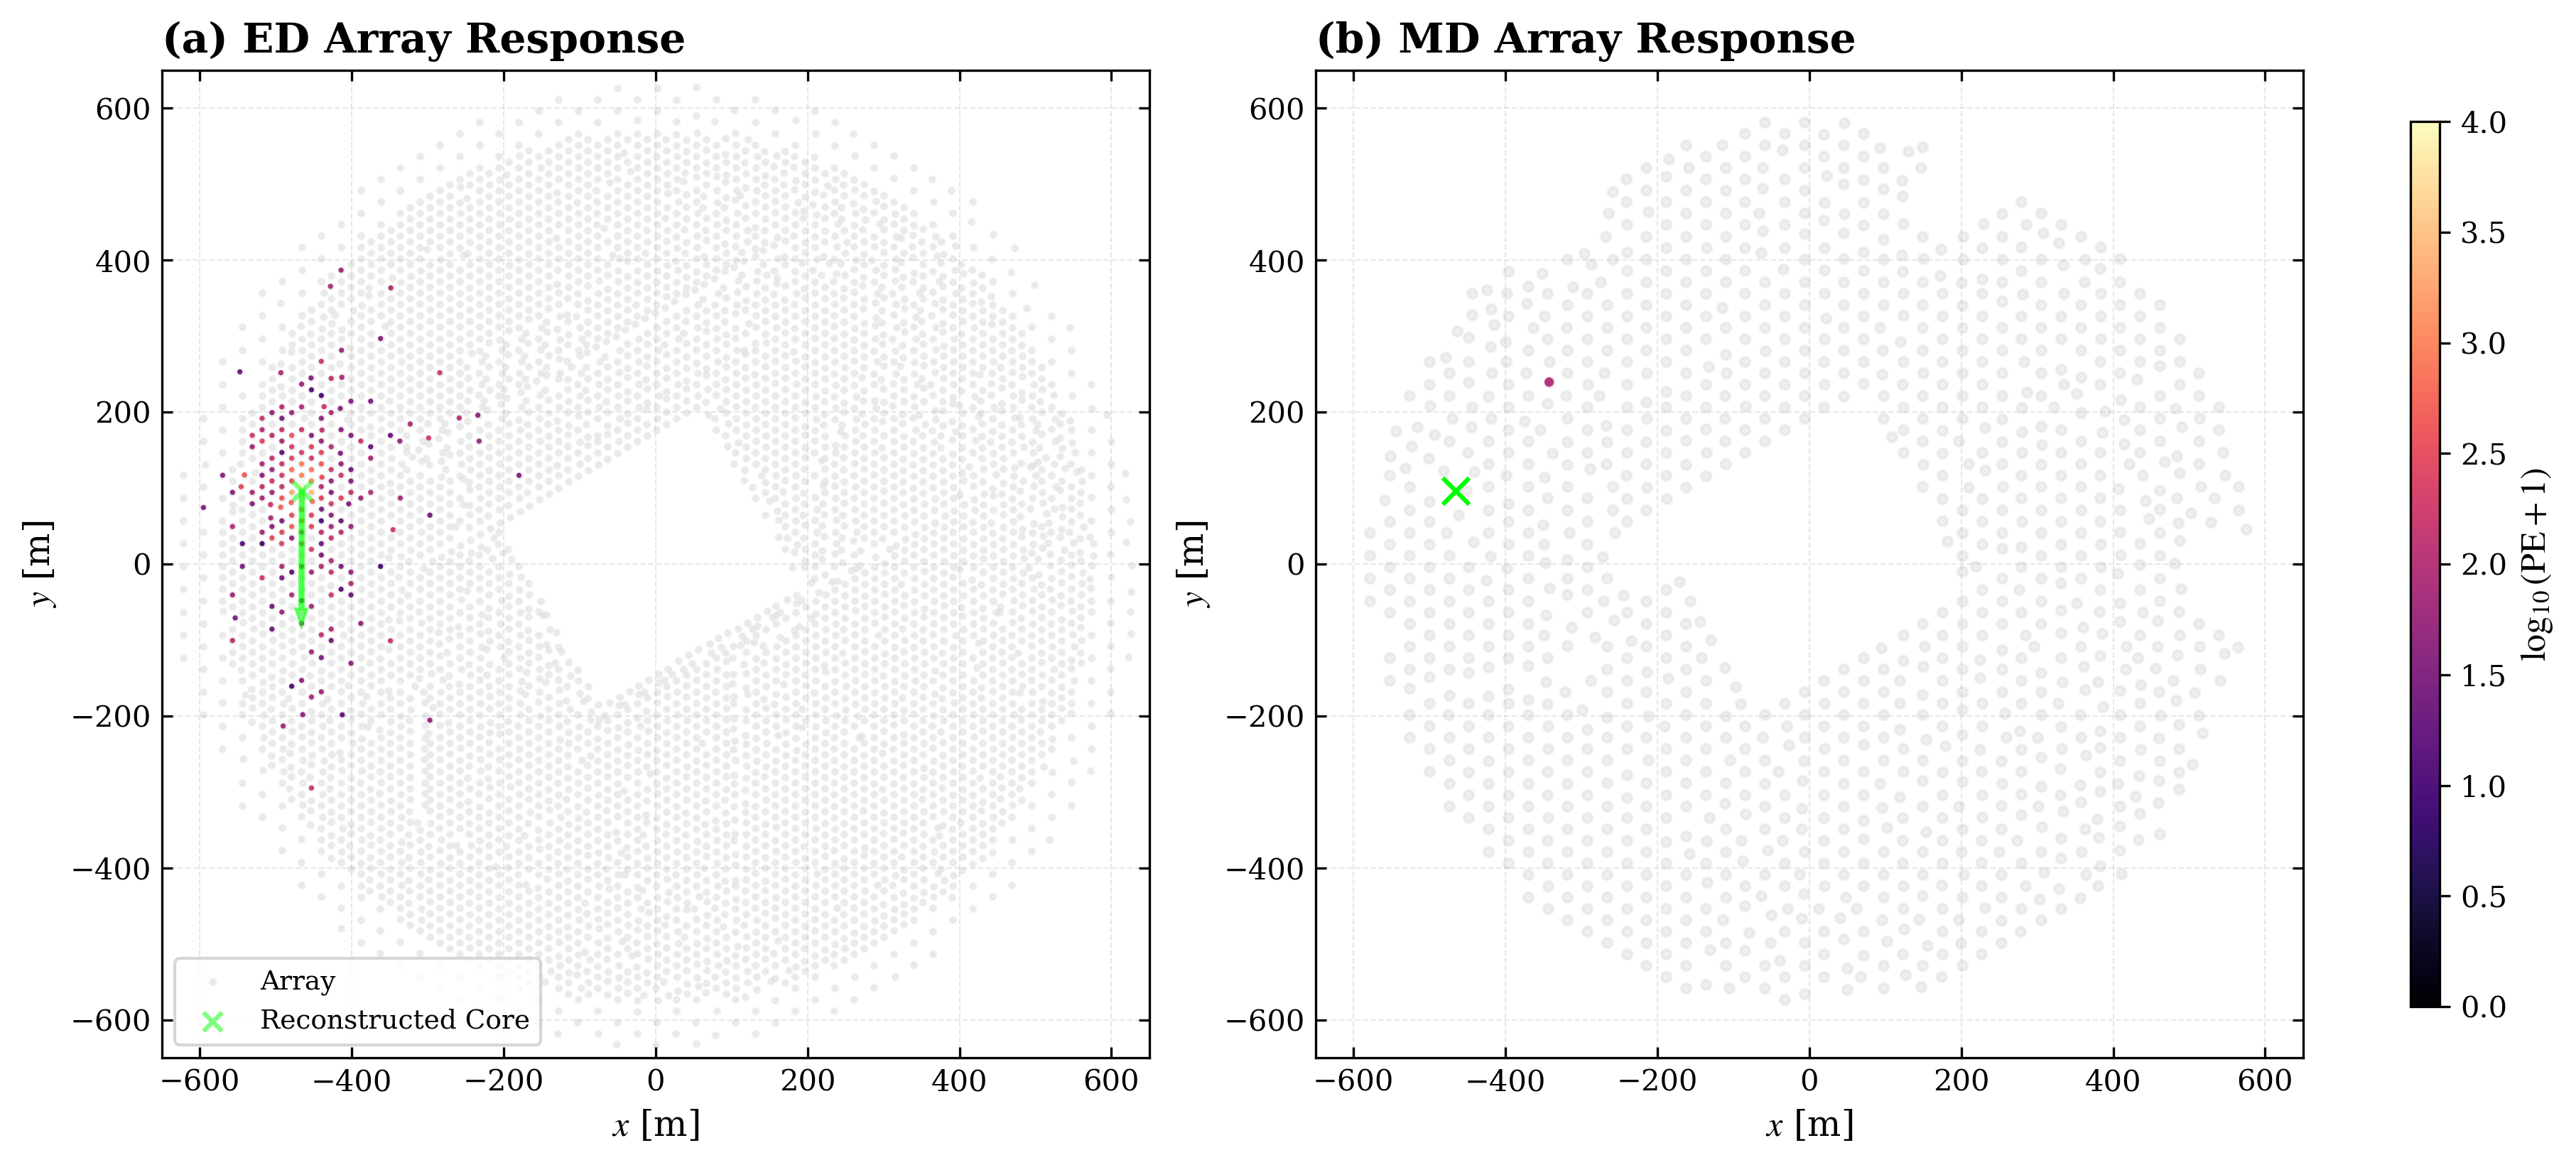

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def event_plot_npz(index, hitsE_all, hitsM_all, df_params, flag=7, figpath=None):
    # 配置学术字体
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["mathtext.fontset"] = "stix"
    
    # 1. 加载阵列位置
    ED_pos, MD_pos = load_pos(flag)

    # 2. 提取数据
    hE = hitsE_all[index]
    hM = hitsM_all[index]
    row = df_params.iloc[index]
    core = [row['rec_x'], row['rec_y']]
    theta, phi = row['rec_theta'], row['rec_phi']

    # 3. 计算指向箭头 (转换坐标系或方向)
    # 这里的 dx, dy 逻辑保持原样，但增加 arrow_width 的美化
    arrow_len = 220
    dx = -np.sin(theta) * np.sin(phi) * arrow_len
    dy = np.sin(theta) * np.cos(phi) * arrow_len

    # 4. 开始绘图
    # 使用 constrained_layout 替代 tight_layout，能更好地处理 colorbar 间距
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5), constrained_layout=True, dpi=300)
    
    # 公用的绘图参数
    scatter_kwargs = {
        'cmap': 'magma', # 更有科研质感的渐变色
        'vmin': 0, 
        'vmax': 4,       # 固定 log10(PE) 范围，方便左右对比
        'edgecolors': 'none'
    }

    # --- 左图：ED Hits ---
    ax1.scatter(ED_pos['x'], ED_pos['y'], c='#E0E0E0', s=3, alpha=0.5, label='Array', zorder=1)
    sc1 = ax1.scatter(hE[:, 0], hE[:, 1], c=np.log10(hE[:, 3] + 1), 
                      s=3, zorder=3, **scatter_kwargs)
    
    # 核心位置与箭头
    ax1.scatter(core[0], core[1], c='#00FF00', s=40, marker='x', label='Reconstructed Core', zorder=10, alpha=0.5)
    ax1.arrow(core[0], core[1], dx, dy, color='#00FF00', width=5, head_width=15, alpha=0.5 ,
              length_includes_head=True, zorder=11)
    
    ax1.set_title('(a) ED Array Response', fontsize=14, loc='left', fontweight='bold')

    # --- 右图：MD Hits ---
    ax2.scatter(MD_pos['x'], MD_pos['y'], c='#E0E0E0', s=10, alpha=0.5, zorder=1)
    sc2 = ax2.scatter(hM[:, 0], hM[:, 1], c=np.log10(hM[:, 3] + 1), 
                      s=10, zorder=3, **scatter_kwargs)
    
    ax2.scatter(core[0], core[1], c='#00FF00', s=80, marker='x', zorder=10)
    
    ax2.set_title('(b) MD Array Response', fontsize=14, loc='left', fontweight='bold')

    # 设置统一的 Colorbar
    cbar = fig.colorbar(sc2, ax=[ax1, ax2], location='right', aspect=30, shrink=0.8)
    cbar.set_label(r'$\log_{10}(\text{PE} + 1)$', fontsize=12)

    # 坐标轴细节优化
    for i, ax in enumerate([ax1, ax2]):
        ax.set_aspect('equal')
        ax.set_xlabel('$x$ [m]', fontsize=12)
        ax.set_ylabel('$y$ [m]', fontsize=12)
        ax.set_xlim(-650, 650)
        ax.set_ylim(-650, 650)
        ax.tick_params(direction='in', top=True, right=True)
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
        if i == 0: ax.legend(loc='lower left', fontsize=9, framealpha=0.8)

    # 如果需要保存
    if figpath:
        plt.savefig(figpath, bbox_inches='tight', dpi=300)
    plt.show()

# 调用
# event_plot_npz_formal(0, hitsE, hitsM, mn_df, flag=7, figpath="event_display.pdf")
mn_file="/home/zhonghua/data/Dataset_Filted/Monopole/filted_Monopole_1e10_merged_1000_70_dataset_muon_smooth.npz"
mn_data = np.load(mn_file, allow_pickle=True)
hitsE = mn_data['hitsE']; hitsM = mn_data['hitsM']; mn_df = pd.DataFrame(mn_data['params'], columns=mn_data['param_names'])

event_plot_npz(100, hitsE, hitsM, mn_df, flag=7, figpath="./figures/monopole_1e10_event_example.pdf")


In [15]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

class EnergyReconstructor:
    def __init__(self, model_path=None):
        # 初始化 XGBoost 参数
        self.params = {
            'n_estimators': 1000,
            'learning_rate': 0.03,
            'max_depth': 8,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'n_jobs': -1,
            'random_state': 42
        }
        self.model = xgb.XGBRegressor(**self.params)
        if model_path:
            self.model.load_model(model_path)

    def load_and_preprocess(self, filepath):
        """加载并清洗数据，执行降采样策略"""
        data = np.load(filepath, allow_pickle=True)
        df = pd.DataFrame(data['params'], columns=data['param_names'])
        
        # 类型转换与清洗
        cols_to_numeric = ['NuW3', 'rec_theta', 'dr', 'trueE']
        for col in cols_to_numeric:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # 特征工程：取对数
        # 注意：这里需要处理 NuW3 <= 0 的情况，防止 log 报错，虽然物理上不应存在
        df = df[df['NuW3'] > 0].copy()
        df['log_NuW3'] = np.log10(df['NuW3'])
        
        # 降采样策略：平衡高低能段数据分布
        # 阈值 3.16e9 (即 10^9.5 GeV)
        threshold = 3.16e9
        df_low = df[df['trueE'] < threshold].sample(frac=0.3, random_state=42)
        df_high = df[df['trueE'] >= threshold]
        df_balanced = pd.concat([df_low, df_high], ignore_index=True)
        
        # 物理截断：dr > 0 且 theta <= 70度
        mask = (df_balanced['dr'] > 0) & \
               (df_balanced['rec_theta'] > 0) & \
               (df_balanced['rec_theta'] <= np.deg2rad(70))
        
        clean_df = df_balanced[mask].copy()
        
        # 准备训练数据
        # 目标：log10(E/1e8) -> 归一化可以加速收敛
        X = clean_df[['log_NuW3', 'rec_theta']]
        y = np.log10(clean_df['trueE'] / 1e8)
        
        return X, y, clean_df['trueE'] # 返回原始能量用于后续评估

    def train(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        print("Training XGBoost model...")
        self.model.fit(X_train, y_train)
        
        y_pred = self.model.predict(X_test)
        
        # 基础评估
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"Model Evaluation -> MAE: {mae:.4f}, R^2: {r2:.4f}")
        
        # 保存模型
        # self.model.save_model("./models/energy_correction_xgb.json")
        # joblib.dump(self.model, "./models/energy_correction_xgb.pkl") # 可选
        
        return X_test, y_test, y_pred

# --- 使用示例 ---
agent = EnergyReconstructor()
X, y, E_true_raw = agent.load_and_preprocess("/home/zhonghua/data/Dataset_Filted/Monopole/filted_all_recE_0.5_4.5_dataset_muon.npz")
X_test, y_test, y_pred = agent.train(X, y)


/home/zhonghua/miniconda3/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Training XGBoost model...
Model Evaluation -> MAE: 0.0763, R^2: 0.9626


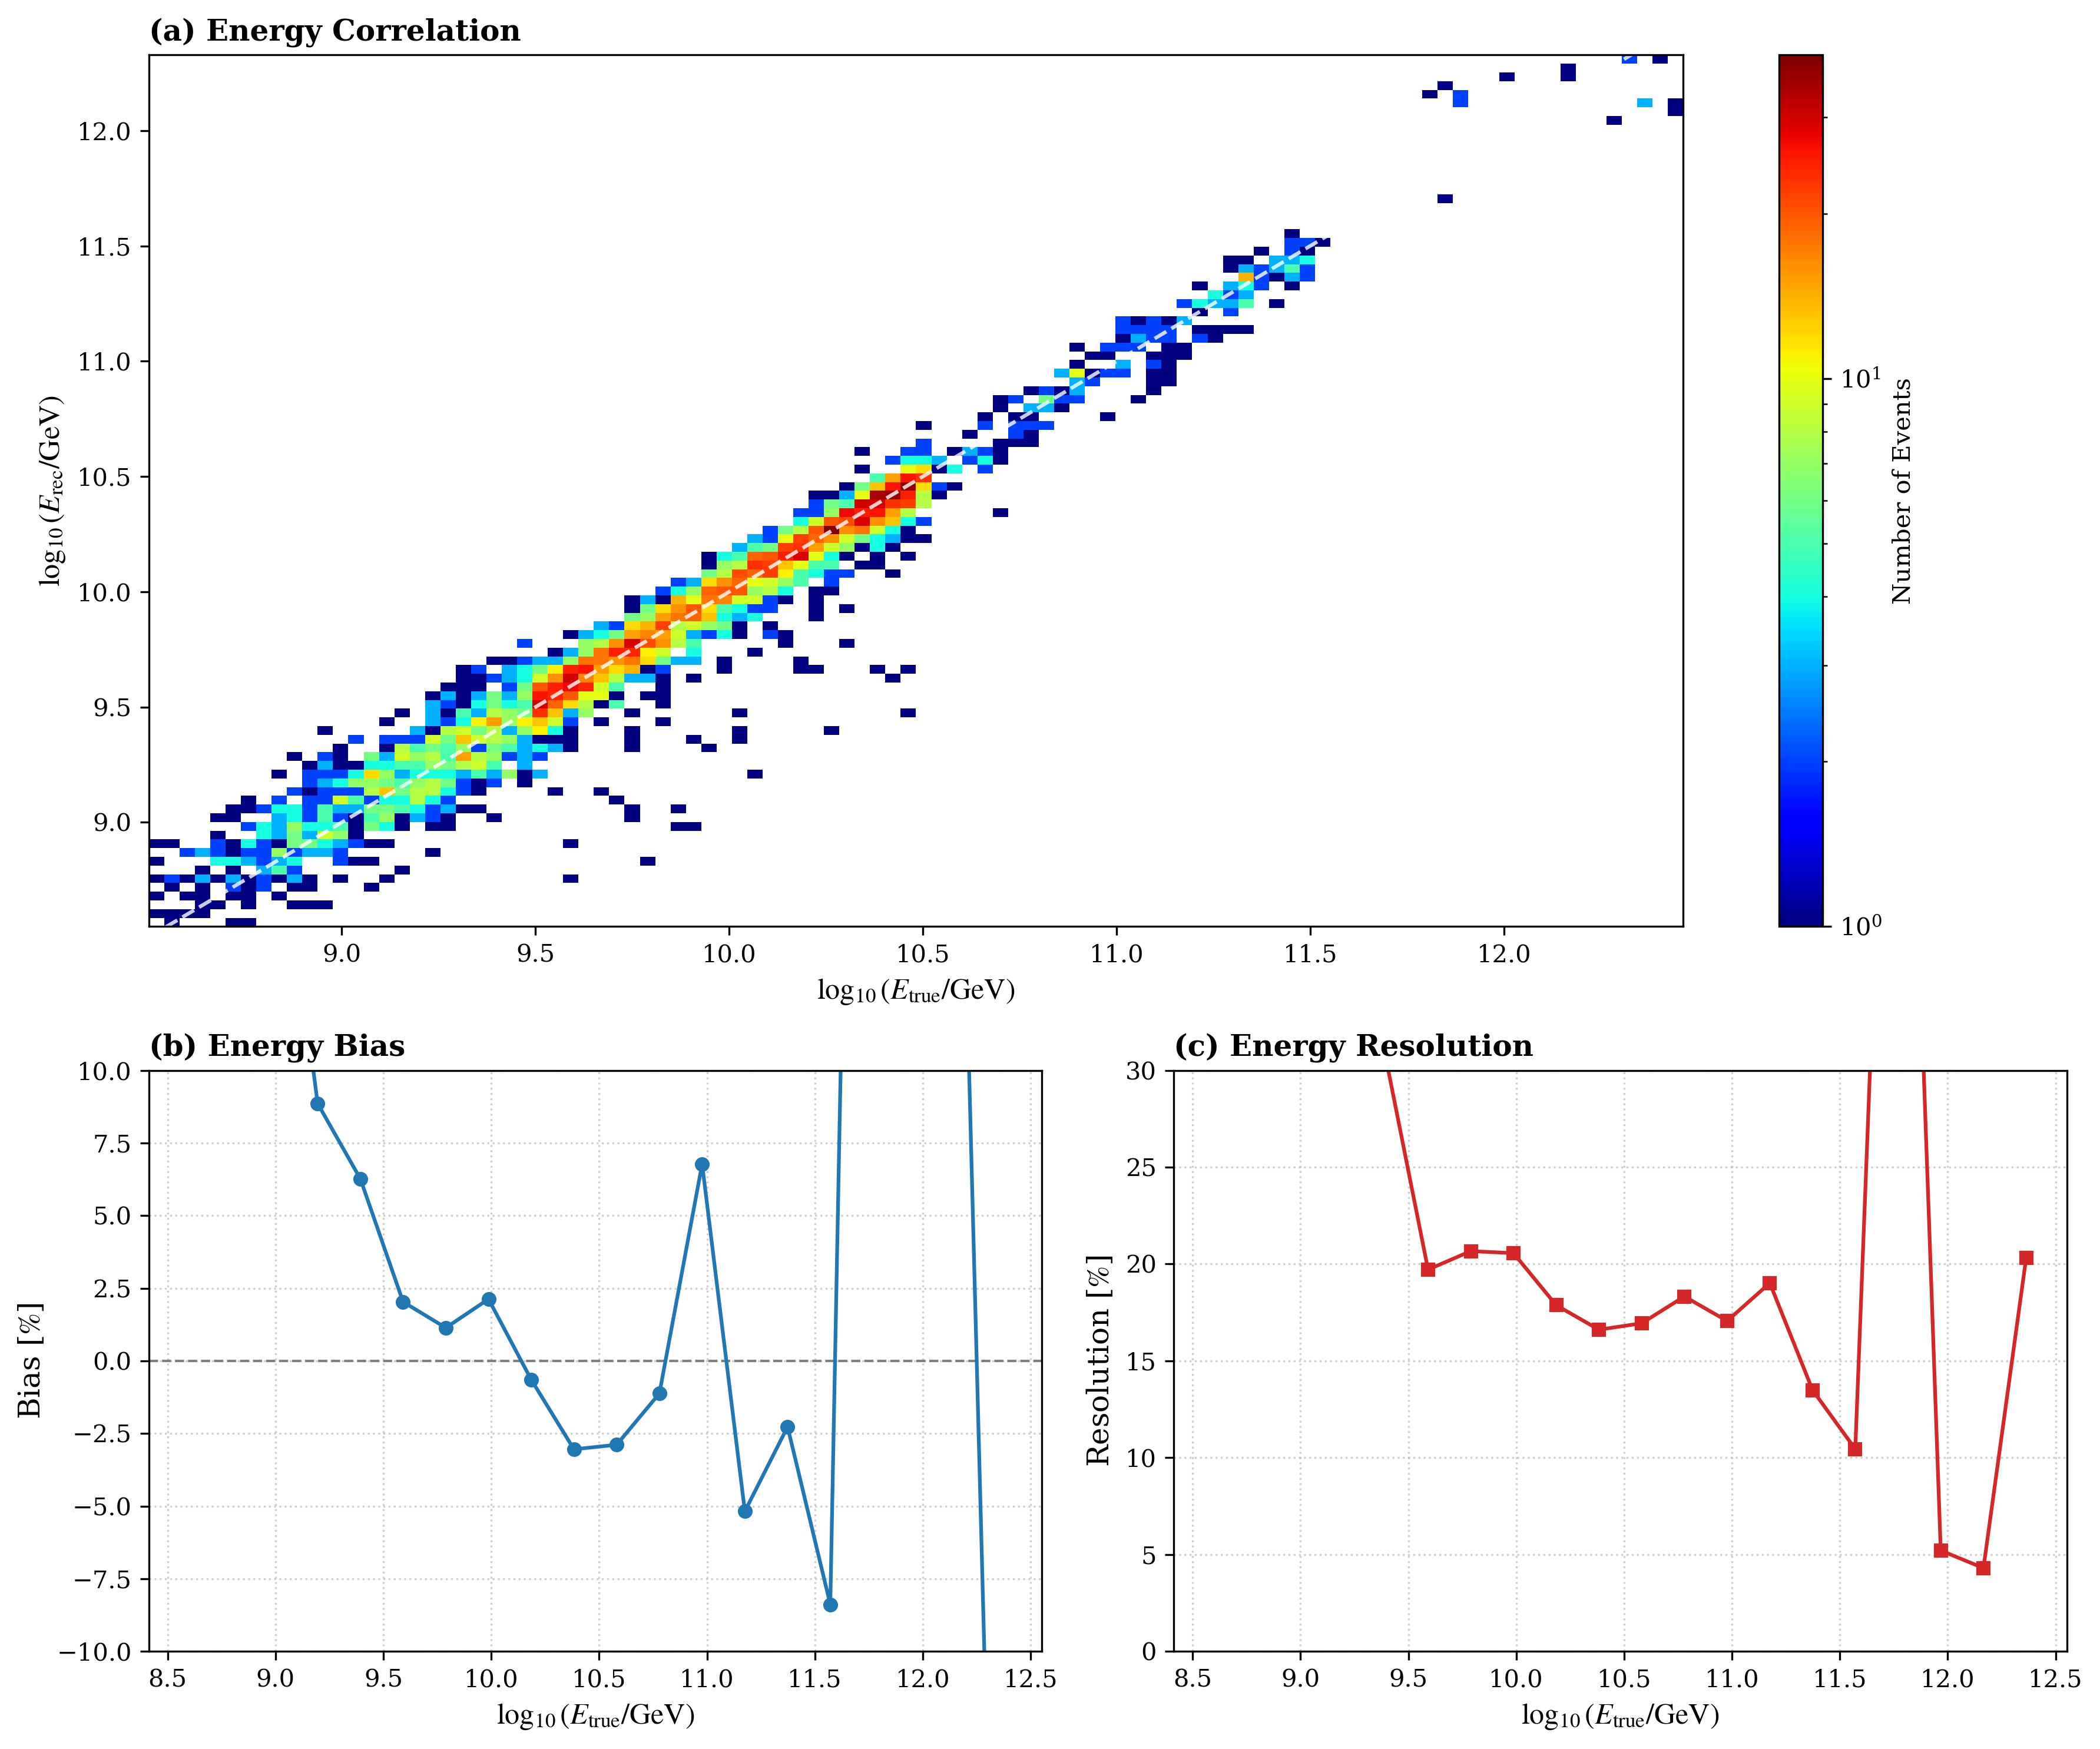

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import binned_statistic

def plot_energy_performance(y_true_log, y_pred_log, E_ref=1e8):
    # 还原为线性能量值
    E_true = E_ref * (10**y_true_log)
    E_pred = E_ref * (10**y_pred_log)
    
    # 定义偏差 bias = (E_rec - E_true) / E_true
    bias_vals = (E_pred - E_true) / E_true
    
    # 设置绘图风格
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["mathtext.fontset"] = "stix"
    
    fig = plt.figure(figsize=(12, 10), dpi=300)
    gs = gridspec.GridSpec(2, 2, height_ratios=[1.5, 1])
    
    # --- 图 1: 2D Histogram (Correlation) ---
    ax1 = fig.add_subplot(gs[0, :])
    
    # 绘制 2D 直方图
    h = ax1.hist2d(np.log10(E_true), np.log10(E_pred), bins=100, 
                   cmap='jet', cmin=1, norm='log')
    
    # 绘制 y=x 参考线
    lims = [np.min([ax1.get_xlim(), ax1.get_ylim()]), np.max([ax1.get_xlim(), ax1.get_ylim()])]
    ax1.plot(lims, lims, 'w--', alpha=0.8, linewidth=1.5, label='Ideal Reconstruction')
    
    ax1.set_xlabel(r'$\log_{10}(E_{\text{true}}/\text{GeV})$', fontsize=12)
    ax1.set_ylabel(r'$\log_{10}(E_{\text{rec}}/\text{GeV})$', fontsize=12)
    ax1.set_title('(a) Energy Correlation', loc='left', fontweight='bold')
    
    # 颜色条
    cbar = plt.colorbar(h[3], ax=ax1)
    cbar.set_label('Number of Events', fontsize=10)
    
    # --- 计算 Resolution 和 Bias 随能量的变化 ---
    # 将能量分段
    n_bins = 20
    bin_edges = np.linspace(np.log10(E_true).min(), np.log10(E_true).max(), n_bins+1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # 计算每个 bin 内的 mean (Bias) 和 std (Resolution)
    # 注意：更鲁棒的方法是使用高斯拟合，这里用简单的统计作为示例
    mean_bias, _, _ = binned_statistic(np.log10(E_true), bias_vals, statistic='mean', bins=bin_edges)
    resolution, _, _ = binned_statistic(np.log10(E_true), bias_vals, statistic='std', bins=bin_edges)
    
    # --- 图 2: Bias (偏差) ---
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.errorbar(bin_centers, mean_bias * 100, yerr=0, fmt='o-', color='#1f77b4', 
                 markersize=5, linewidth=1.5, capsize=3)
    ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
    
    ax2.set_xlabel(r'$\log_{10}(E_{\text{true}}/\text{GeV})$', fontsize=12)
    ax2.set_ylabel(r'Bias [$\%$]', fontsize=12)
    ax2.set_ylim(-10, 10) # 根据实际情况调整
    ax2.set_title('(b) Energy Bias', loc='left', fontweight='bold')
    ax2.grid(True, linestyle=':', alpha=0.6)

    # --- 图 3: Resolution (分辨率) ---
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(bin_centers, resolution * 100, 's-', color='#d62728', 
             markersize=5, linewidth=1.5)
    
    ax3.set_xlabel(r'$\log_{10}(E_{\text{true}}/\text{GeV})$', fontsize=12)
    ax3.set_ylabel(r'Resolution [$\%$]', fontsize=12)
    ax3.set_ylim(0, 30) # 根据实际情况调整
    ax3.set_title('(c) Energy Resolution', loc='left', fontweight='bold')
    ax3.grid(True, linestyle=':', alpha=0.6)
    
    plt.tight_layout()
    plt.savefig('./figures/energy_reconstruction_performance.pdf', bbox_inches='tight')
    plt.show()

# 假设你已经运行了训练得到了 y_test (真实对数值) 和 y_pred (预测对数值)
plot_energy_performance(y_test, y_pred)


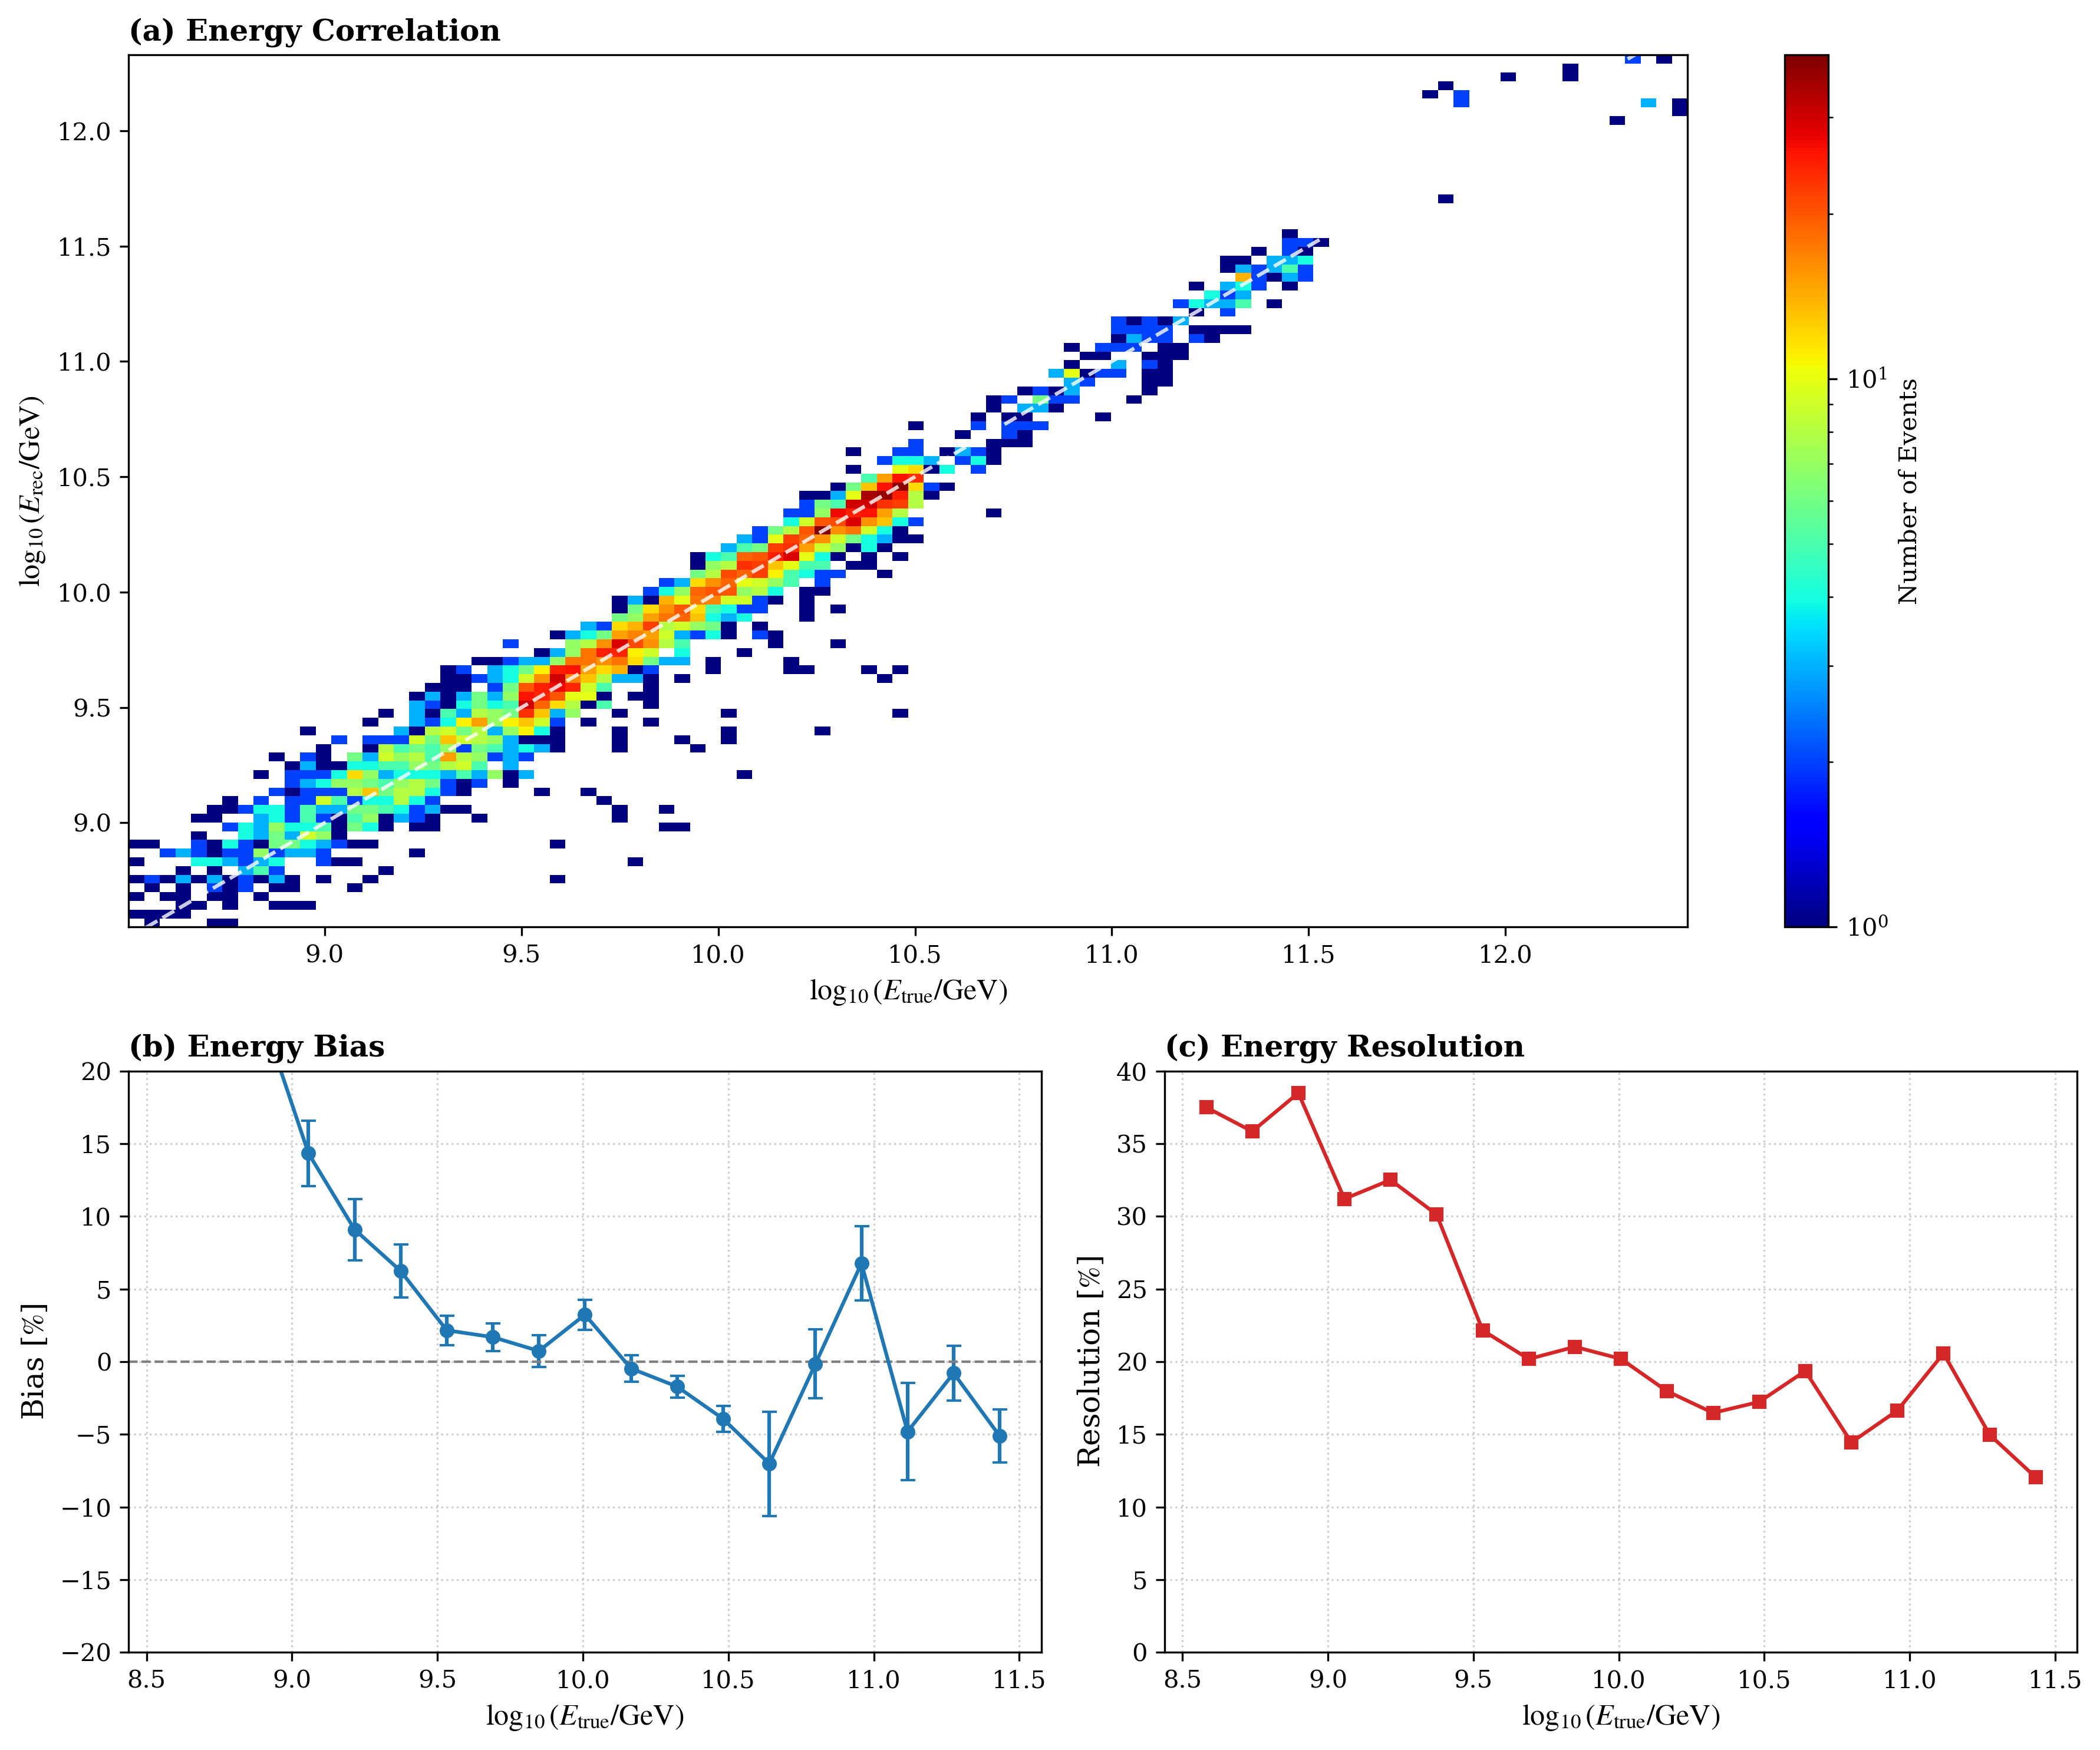

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import binned_statistic

def plot_energy_performance_optimized(y_true_log, y_pred_log, E_ref=1e8, min_events=10):
    """
    min_events: 每个bin最少需要多少个事例才画出来，防止尾部震荡
    """
    # 1. 数据准备
    E_true = E_ref * (10**y_true_log)
    E_pred = E_ref * (10**y_pred_log)
    bias_vals = (E_pred - E_true) / E_true
    
    # 2. 设置绘图风格
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["mathtext.fontset"] = "stix"
    
    fig = plt.figure(figsize=(12, 10), dpi=300)
    gs = gridspec.GridSpec(2, 2, height_ratios=[1.5, 1])
    
    # --- 图 (a): Correlation (保持原样，微调美观) ---
    ax1 = fig.add_subplot(gs[0, :])
    h = ax1.hist2d(np.log10(E_true), np.log10(E_pred), bins=100, 
                   cmap='jet', cmin=1, norm='log') # cmin=1 去掉0值的白底
    
    # 参考线
    lims = [np.min([ax1.get_xlim(), ax1.get_ylim()]), np.max([ax1.get_xlim(), ax1.get_ylim()])]
    ax1.plot(lims, lims, 'w--', alpha=0.8, linewidth=1.5)
    
    ax1.set_xlabel(r'$\log_{10}(E_{\text{true}}/\text{GeV})$', fontsize=12)
    ax1.set_ylabel(r'$\log_{10}(E_{\text{rec}}/\text{GeV})$', fontsize=12)
    ax1.set_title('(a) Energy Correlation', loc='left', fontweight='bold')
    cbar = plt.colorbar(h[3], ax=ax1)
    cbar.set_label('Number of Events')

    # --- 统计计算核心部分 ---
    n_bins = 25 # 适当减少bin的数量以增加每个bin的统计量
    bin_range = (np.min(np.log10(E_true)), np.max(np.log10(E_true)))
    
    # 计算统计量
    count_stat, bin_edges, _ = binned_statistic(np.log10(E_true), bias_vals, statistic='count', bins=n_bins, range=bin_range)
    mean_stat, _, _ = binned_statistic(np.log10(E_true), bias_vals, statistic='mean', bins=n_bins, range=bin_range)
    std_stat, _, _ = binned_statistic(np.log10(E_true), bias_vals, statistic='std', bins=n_bins, range=bin_range)
    
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # *** 关键步骤：掩膜过滤 (Masking) ***
    # 只有当该能量段事例数 > min_events 时才显示
    valid_mask = count_stat >= min_events
    
    x_valid = bin_centers[valid_mask]
    bias_valid = mean_stat[valid_mask] * 100
    res_valid = std_stat[valid_mask] * 100
    
    # 计算 Bias 的误差棒: SEM = Std / sqrt(N)
    bias_err = (std_stat[valid_mask] / np.sqrt(count_stat[valid_mask])) * 100
    
    # --- 图 (b): Bias (带误差棒) ---
    ax2 = fig.add_subplot(gs[1, 0])
    
    # 绘制带误差棒的点
    ax2.errorbar(x_valid, bias_valid, yerr=bias_err, fmt='o-', color='#1f77b4', 
                 markersize=5, linewidth=1.5, capsize=3, label='Bias')
    
    ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax2.set_xlabel(r'$\log_{10}(E_{\text{true}}/\text{GeV})$', fontsize=12)
    ax2.set_ylabel(r'Bias [$\%$]', fontsize=12)
    ax2.set_title('(b) Energy Bias', loc='left', fontweight='bold')
    
    # 限制Y轴范围，避免极大值破坏视图 (例如限制在 +/- 15%)
    # 根据你的数据，低能端可能有较大Bias，所以设宽一点，但不要无限大
    ax2.set_ylim(-20, 20) 
    ax2.grid(True, linestyle=':', alpha=0.6)

    # --- 图 (c): Resolution ---
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(x_valid, res_valid, 's-', color='#d62728', markersize=5, linewidth=1.5)
    
    ax3.set_xlabel(r'$\log_{10}(E_{\text{true}}/\text{GeV})$', fontsize=12)
    ax3.set_ylabel(r'Resolution [$\%$]', fontsize=12)
    ax3.set_title('(c) Energy Resolution', loc='left', fontweight='bold')
    
    # 设置合理的 Y 轴上限，比如 40%，去掉那些异常飞出去的点
    ax3.set_ylim(0, 40) 
    ax3.grid(True, linestyle=':', alpha=0.6)
    
    plt.tight_layout()
    plt.savefig('./figures/energy_reconstruction.pdf', bbox_inches='tight')
    plt.show()

# 调用示例
plot_energy_performance_optimized(y_test, y_pred, min_events=15)
